
# 线性模型的卷积神经网络特征

In [1]:
# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
import imp
import utils
imp.reload(utils)
from utils import *

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 介绍

我们需要找到一种方法，将imagenet的预测转换成猫或狗的二分概率，因为这是Kaggle竞赛要求我们提交的。我们可以使用imagenet层级来下载每个dog和cat组中的所有imagenet类别的列表，然后可以用各种方式解决我们的问题，例如:

- 找到最大的可能是猫或狗的概率，然后使用这个概率对应的标签值
- 计算所有猫类的平均概率，并与所有狗类的平均概率进行比较。

但这些方法也有一些缺点:

- 我们本应该数据中学到一些知识，而不是手动的硬编码。
- 忽略预测中可获得的资料;例如，如果模型预测图像中有一根骨头，它更可能是狗而不是猫。

这两个问题的一个非常简单的解决方案是学习一个线性模型，该模型使用来自imagenet模型的1000个预测作为输入，而dog/cat标签作为目标。

In [2]:
%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils
imp.reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data

In [3]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input,Dense,Activation,ZeroPadding2D,Dropout,Conv2D,MaxPool2D,Flatten,Lambda,BatchNormalization
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image
np.random.seed(42)

## Keras中的线性模型

It turns out that each of the Dense() layers is just a *linear model*, followed by a simple *activation function*. We'll learn about the activation function later - first, let's review how linear models work.

每一个全连接层原来就是一个线性模型，

A linear model is (as I'm sure you know) simply a model where each row is calculated as *sum(row &#42; weights)*, where *weights* needs to be learnt from the data, and will be the same for every row. For example, let's create some data that we know is linearly related:

In [4]:
x = random((30,2))
x.shape

(30, 2)

In [5]:
x[:5]

array([[0.3745, 0.9507],
       [0.732 , 0.5987],
       [0.156 , 0.156 ],
       [0.0581, 0.8662],
       [0.6011, 0.7081]])

In [6]:
x = random((30,2))
y = np.dot(x, [2., 3.]) + 1.  # 直接定义参数[2,3] 1

In [7]:
x[:5]

array([[0.3887, 0.2713],
       [0.8287, 0.3568],
       [0.2809, 0.5427],
       [0.1409, 0.8022],
       [0.0746, 0.9869]])

In [8]:
type(y)

numpy.ndarray

In [9]:
y.shape

(30,)

In [10]:
y

array([2.5914, 3.7277, 3.19  , 3.6884, 4.1098, 3.1406, 3.4574, 4.6007, 2.7647, 2.0645, 4.5961,
       1.8525, 2.5975, 4.3719, 4.1911, 3.3789, 4.2054, 4.0233, 3.3281, 1.3745, 2.9721, 3.1544,
       3.563 , 4.0874, 1.6885, 2.0632, 5.2838, 4.8812, 3.1671, 4.4031])

We can use keras to create a simple linear model (*Dense()* - with no activation - in Keras) and optimize it using SGD to minimize mean squared error (*mse*):

建立一个Keras的顺序模型，不适用激活函数，这意味着这是一个线性模型，使用`SGD`优化算法

In [11]:
lm = Sequential([Dense(1,input_shape=[2,])])
lm.compile(optimizer=SGD(lr=0.01),loss='mse')
lm.evaluate(x,y,verbose=1)

30/30 [==============================] - 1s 35ms/step


17.28533935546875

上面没有经过训练，直接评估，看到`MSE`误差很大

In [12]:
# 训练
lm.fit(x,y,epochs=200,batch_size=1,verbose=0)

In [13]:
lm.evaluate(x, y, verbose=0)

2.7106448214908596e-06

最后看看训练后的权重，看到很接近2.0，3.0，1.0

In [14]:
lm.get_weights()

[array([[1.9969],
        [2.9948]], dtype=float32), array([1.0042], dtype=float32)]

## 用vgg16的预测值训练线形模型

Using a Dense() layer in this way, we can easily convert the 1,000 predictions given by our model into a probability of dog vs cat--simply train a linear model to take the 1,000 predictions as input, and return dog or cat as output, learning from the Kaggle data. This should be easier and more accurate than manually creating a map from imagenet categories to one dog/cat category. 

### 训练模型

We start with some basic config steps. We copy a small amount of our data into a 'sample' directory, with the exact same structure as our 'train' directory--this is *always* a good idea in *all* machine learning, since we should do all of our initial testing using a dataset small enough that we never have to wait for it.

In [15]:
path = "data/dogscats/"
# path = "data/dogscats/"
model_path = "data/dogscats/models/"
if not os.path.exists(model_path): os.mkdir(model_path)

We will process as many images at a time as our graphics card allows. This is a case of trial and error to find the max batch size - the largest size that doesn't give an out of memory error.

In [16]:
# batch_size=100
batch_size=16

引入之前定义好的VGG16模型:

In [17]:
from myvgg16 import Vgg16
#imp.reload(myvgg16)
vgg = Vgg16()
model = vgg.model # 调用自己定义的原始Vgg16模型，而不是finetune模型

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

Our overall approach here will be:
我们这里的总体方法是：

1. 获得每个图片的真实标签值。
2. 获得每个图片属于1000个类型的概率值。
3. 把这些预测简单的作为线性模型的输入。

首先，要获取训练集和验证集：

In [19]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches = get_batches(path+'train', shuffle=False, batch_size=1)

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


每次使用数据的时候重复的读取，变化不是必须的。通过`bcolz`函数我们能够压缩数组，存放到硬盘，`utils.py`提供了很有用的函数

In [20]:
import bcolz
def save_array(fname, arr): 
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname): 
    return bcolz.open(fname)[:]

We have provided a simple function that joins the arrays from all the batches - let's use this to grab the training and validation data:

In [21]:
val_data = get_data(path+'valid')

Found 2000 images belonging to 2 classes.


In [22]:
trn_data = get_data(path+'train')

Found 23000 images belonging to 2 classes.


In [23]:
trn_data.shape

(23000, 3, 224, 224)

In [24]:
save_array(model_path+'train_data.bc', trn_data)
save_array(model_path+'valid_data.bc', val_data)

通过`load_array()`读取：

In [25]:
trn_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')

In [26]:
trn_data[0]

array([[[203., 206., 209., ..., 245., 241., 239.],
        [203., 206., 209., ..., 245., 242., 240.],
        [203., 206., 209., ..., 245., 243., 241.],
        ...,
        [154., 155., 156., ...,   3.,   3.,   3.],
        [153., 153., 154., ...,   2.,   2.,   2.],
        [151., 152., 153., ...,   1.,   1.,   1.]],

       [[164., 167., 170., ..., 203., 202., 200.],
        [164., 167., 170., ..., 205., 203., 201.],
        [164., 167., 170., ..., 204., 204., 202.],
        ...,
        [123., 124., 125., ...,   3.,   3.,   3.],
        [122., 122., 123., ...,   2.,   2.,   2.],
        [120., 121., 122., ...,   1.,   1.,   1.]],

       [[ 87.,  90.,  93., ..., 119., 123., 121.],
        [ 87.,  90.,  93., ..., 120., 124., 122.],
        [ 87.,  90.,  93., ..., 122., 125., 123.],
        ...,
        [ 56.,  57.,  58., ...,   1.,   1.,   1.],
        [ 55.,  55.,  56., ...,   0.,   0.,   0.],
        [ 53.,  54.,  55., ...,   0.,   0.,   0.]]], dtype=float32)

In [27]:
val_data.shape

(2000, 3, 224, 224)

Keras returns *classes* as a single column, so we convert to one hot encoding

Keras 返回的*classes* 是一维向量，所以我们要转换成独热编码

In [28]:
def onehot(x): 
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [29]:
val_classes = val_batches.classes # 原始的一维向量的类别
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes) # onehot编码的

In [30]:
print("val_classes:",val_classes)
print("trn_classes:",trn_classes)

val_classes: [0 0 0 ... 1 1 1]
trn_classes: [0 0 0 ... 1 1 1]


In [31]:
# 查看一个编码 ，这是一个onehot编码
val_labels[0]

array([1., 0.])

In [32]:
trn_labels.shape

(23000, 2)

In [33]:
trn_labels[:4]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

...and their 1,000 imagenet probabilties from VGG16--these will be the *features* for our linear model:

每个图片的1000种类别的概率作为我们线性模型的`特征值`

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [35]:
trn_features = model.predict(trn_data, batch_size=batch_size) 
val_features = model.predict(val_data, batch_size=batch_size)

In [36]:
trn_features.shape

(23000, 1000)

In [37]:
save_array(model_path+'train_lastlayer_features.bc', trn_features)
save_array(model_path+'valid_lastlayer_features.bc', val_features)

We can load our training and validation features later without recalculating them:

In [38]:
trn_features = load_array(model_path+'train_lastlayer_features.bc')
val_features = load_array(model_path+'valid_lastlayer_features.bc')

定义线性模型：

In [39]:
lm = Sequential([Dense(2,activation='softmax',input_shape=(1000,))])
lm.compile(optimizer=RMSprop(lr=0.1),loss='categorical_crossentropy',metrics=['accuracy'])

We're ready to fit the model!

In [40]:
batch_size=16

In [41]:
lm.fit(trn_features,trn_labels,epochs=10,batch_size=batch_size,validation_data=(val_features,val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/10
23000/23000 [==============================] - 4s 183us/step - loss: 0.3763 - acc: 0.8594 - val_loss: 0.4012 - val_acc: 0.8645
Epoch 2/10
23000/23000 [==============================] - 4s 158us/step - loss: 0.4121 - acc: 0.8656 - val_loss: 0.4421 - val_acc: 0.8670
Epoch 3/10
23000/23000 [==============================] - 4s 161us/step - loss: 0.4291 - acc: 0.8704 - val_loss: 0.4911 - val_acc: 0.8660
Epoch 4/10
23000/23000 [==============================] - 4s 161us/step - loss: 0.4534 - acc: 0.8709 - val_loss: 0.5135 - val_acc: 0.8670
Epoch 5/10
23000/23000 [==============================] - 4s 159us/step - loss: 0.4718 - acc: 0.8720 - val_loss: 0.5298 - val_acc: 0.8660
Epoch 6/10
23000/23000 [==============================] - 4s 159us/step - loss: 0.4884 - acc: 0.8720 - val_loss: 0.5478 - val_acc: 0.8720
Epoch 7/10
23000/23000 [==============================] - 4s 159us/step - loss: 0.5007 - acc: 0.8746 - val_loss: 0.5628 - v

In [42]:
lm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2)                 2002      
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
_________________________________________________________________


### 展示模型预测

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to handle that - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random 随机的分类正确的
2. A few incorrect labels at random 随机的分类错误的
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we, if anything, we can from these (in general, these are particularly useful for debugging problems in the model; since this model is so simple, there may not be too much to learn at this stage.)

在验证集上预测，这样我们能找到正确和不正确的样本：

In [43]:
val_features

array([[6.8475e-06, 1.6689e-06, 6.1381e-07, ..., 4.1279e-05, 1.2564e-03, 1.2930e-05],
       [2.1105e-06, 3.7982e-05, 4.6157e-06, ..., 1.1608e-05, 2.7110e-04, 1.5983e-04],
       [9.9811e-07, 1.2790e-05, 5.2557e-07, ..., 2.0450e-06, 8.3339e-06, 1.4718e-04],
       ...,
       [1.2637e-06, 3.0298e-07, 1.1776e-06, ..., 1.0079e-06, 8.2599e-06, 3.5690e-04],
       [1.3638e-07, 1.3226e-08, 5.1778e-05, ..., 2.0121e-07, 6.7783e-06, 3.1354e-05],
       [4.4331e-06, 2.9501e-06, 5.6086e-06, ..., 9.5832e-07, 4.7147e-05, 3.0456e-05]],
      dtype=float32)

In [44]:
preds = lm.predict(val_features,batch_size=batch_size) # 预测概率，而不是类别值

In [45]:
preds

array([[2.8740e-04, 9.9971e-01],
       [9.9477e-01, 5.2264e-03],
       [1.0000e+00, 1.2498e-09],
       ...,
       [1.3690e-02, 9.8631e-01],
       [1.1152e-01, 8.8848e-01],
       [6.7649e-02, 9.3235e-01]], dtype=float32)

In [46]:
np.argmax(preds,axis=1)

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

In [47]:
preds = lm.predict_classes(val_features, batch_size=batch_size) # 直接预测是类别值，之前定义好的0，1

In [48]:
preds # 是不是狗的标签

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

In [49]:
probs = lm.predict_proba(val_features, batch_size=batch_size)

In [50]:
probs

array([[2.8740e-04, 9.9971e-01],
       [9.9477e-01, 5.2264e-03],
       [1.0000e+00, 1.2498e-09],
       ...,
       [1.3690e-02, 9.8631e-01],
       [1.1152e-01, 8.8848e-01],
       [6.7649e-02, 9.3235e-01]], dtype=float32)

**这个看到这个函数其实跟`predict`是一样的**

Get the filenames for the validation set, so we can view images:

Keras的batch有很多有用的方法：

In [51]:
val_batches.class_indices # 获得类别索引说明

{'cats': 0, 'dogs': 1}

In [52]:
filenames = val_batches.filenames

In [53]:
# Number of images to view for each visualization task
n_view = 4

根据索引画出验证集的图片：

In [54]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

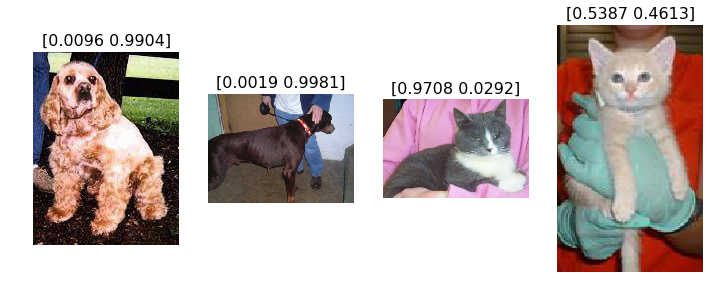

In [55]:
#1. 随机的分类正确的，

correct = np.where(preds ==val_labels[:,1])[0] # 所有分类正确的索引
idx = permutation(correct)[:n_view]
plots_idx(idx,probs[idx])

In [56]:
probs[idx]

array([[0.0096, 0.9904],
       [0.0019, 0.9981],
       [0.9708, 0.0292],
       [0.5387, 0.4613]], dtype=float32)

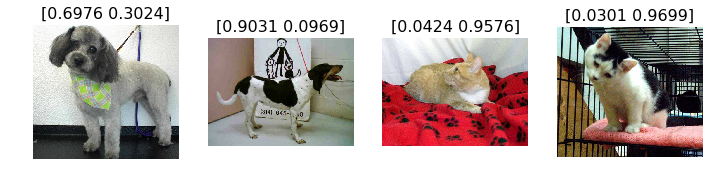

In [57]:
#2. 随机的分类不正确的
incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

In [58]:
#3 分类概率最高的是猫，实际上也是猫
correct_cats = np.where((preds==0)&(preds==val_labels[:,1]))[0]

probs[correct_cats] # 所有的分类是猫，切争取的概率值

array([[9.9477e-01, 5.2264e-03],
       [1.0000e+00, 1.2498e-09],
       [9.8561e-01, 1.4393e-02],
       ...,
       [8.5192e-01, 1.4808e-01],
       [1.0000e+00, 8.0086e-09],
       [8.7883e-01, 1.2117e-01]], dtype=float32)

In [59]:
# a[::-1] # 省略范围的开始下标和结束下标，步长为-1，整个数组头尾颠倒
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:n_view]
most_correct_cats

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int64)

In [60]:
correct_cats[most_correct_cats]

array([[2, 1],
       [2, 1],
       [2, 1],
       [2, 1]], dtype=int64)

In [61]:
probs[correct_cats][most_correct_cats]

array([[[1.0000e+00, 1.2498e-09],
        [9.9477e-01, 5.2264e-03]],

       [[1.0000e+00, 1.2498e-09],
        [9.9477e-01, 5.2264e-03]],

       [[1.0000e+00, 1.2498e-09],
        [9.9477e-01, 5.2264e-03]],

       [[1.0000e+00, 1.2498e-09],
        [9.9477e-01, 5.2264e-03]]], dtype=float32)

In [62]:
#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((preds==0) & (preds==val_labels[:,1]))[0]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats])

TypeError: only integer scalar arrays can be converted to a scalar index

In [63]:
# as above, but dogs
correct_dogs = np.where((preds==1) & (preds==val_labels[:,1]))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], 1-probs[correct_dogs][most_correct_dogs])

TypeError: only integer scalar arrays can be converted to a scalar index

In [64]:
#3. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((preds==0) & (preds!=val_labels[:,1]))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][:n_view]
if len(most_incorrect_cats):
    plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])
else:
    print('No incorrect cats!')

TypeError: only integer scalar arrays can be converted to a scalar index

In [65]:
#3. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((preds==1) & (preds!=val_labels[:,1]))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[:n_view]
if len(most_incorrect_dogs):
    plots_idx(incorrect_dogs[most_incorrect_dogs], 1-probs[incorrect_dogs][most_incorrect_dogs])
else:
    print('No incorrect dogs!')

TypeError: only integer scalar arrays can be converted to a scalar index

In [66]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

TypeError: only integer scalar arrays can be converted to a scalar index

对于2分类任务来说，展示分类效果的应该是混淆矩阵最好：`Scikit-learn`提供一个方便函数

In [67]:
cm = confusion_matrix(val_classes, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[870 130]
 [139 861]]


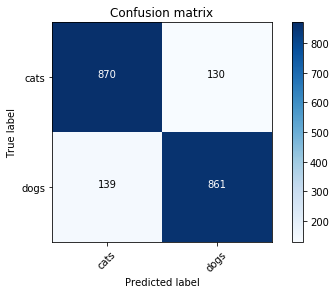

In [68]:
plot_confusion_matrix(cm, val_batches.class_indices)

### 关于激活函数

Do you remember how we defined our linear model? Here it is again for reference:

```python
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
```

And do you remember the definition of a fully connected layer in the original VGG?:

```python
model.add(Dense(4096, activation='relu'))
```

You might we wondering, what's going on with that *activation* parameter? Adding an 'activation' parameter to a layer in Keras causes an additional function to be called after the layer is calculated. You'll recall that we had no such parameter in our most basic linear model at the start of this lesson - that's because a simple linear model has no *activation function*. But nearly all deep model layers have an activation function - specifically, a *non-linear* activation function, such as tanh, sigmoid (```1/(1+exp(x))```), or relu (```max(0,x)```, called the *rectified linear* function). Why?

The reason for this is that if you stack purely linear layers on top of each other, then you just end up with a linear layer! For instance, if your first layer was ```2*x```, and your second was ```-2*x```, then the combination is: ```-2*(2*x) = -4*x```. If that's all we were able to do with deep learning, it wouldn't be very deep! But what if we added a relu activation after our first layer? Then the combination would be: ```-2 * max(0, 2*x)```. As you can see, that does not simplify to just a linear function like the previous example--and indeed we can stack as many of these on top of each other as we wish, to create arbitrarily complex functions.

And why would we want to do that? Because it turns out that such a stack of linear functions and non-linear activations can approximate any other function just as close as we want. So we can **use it to model anything**! This extraordinary insight is known as the *universal approximation theorem*. For a visual understanding of how and why this works, I strongly recommend you read Michael Nielsen's [excellent interactive visual tutorial](http://neuralnetworksanddeeplearning.com/chap4.html).

The last layer generally needs a different activation function to the other layers--because we want to encourage the last layer's output to be of an appropriate form for our particular problem. For instance, if our output is a one hot encoded categorical variable, we want our final layer's activations to add to one (so they can be treated as probabilities) and to have generally a single activation much higher than the rest (since with one hot encoding we have just a single 'one', and all other target outputs are zero). Our classication problems will always have this form, so we will introduce the activation function that has these properties: the *softmax* function. Softmax is defined as (for the i'th output activation): ```exp(x[i]) / sum(exp(x))```.

I suggest you try playing with that function in a spreadsheet to get a sense of how it behaves.

We will see other activation functions later in this course - but relu (and minor variations) for intermediate layers and softmax for output layers will be by far the most common.

# 更改模型

## 重新训练线形模型的最后一层

Since the original VGG16 network's last layer is Dense (i.e. a linear model) it seems a little odd that we are adding an additional linear model on top of it. This is especially true since the last layer had a softmax activation, which is an odd choice for an intermediate layer--and by adding an extra layer on top of it, we have made it an intermediate layer. What if we just removed the original final layer and replaced it with one that we train for the purpose of distinguishing cats and dogs? It turns out that this is a good idea - as we'll see!

We start by removing the last layer, and telling Keras that we want to fix the weights in all the other layers (since we aren't looking to learn new parameters for those other layers).

In [69]:
vgg.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [70]:
model.pop()
for layer in model.layers: 
    layer.trainable=False

**Careful!** Now that we've modified the definition of *model*, be careful not to rerun any code in the previous sections, without first recreating the model from scratch! (Yes, I made that mistake myself, which is why I'm warning you about it now...)

Now we're ready to add our new final layer...

In [71]:
model.add(Dense(2, activation='softmax'))

In [72]:
??vgg.finetune

...and compile our updated model, and set up our batches to use the preprocessed images (note that now we will also *shuffle* the training batches, to add more randomness when using multiple epochs):

In [73]:
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

定义一个非常简单的函数去训练模型：

In [74]:
def fit_model(model, batches, val_batches, n_epoch=1):
    model.fit_generator(batches,steps_per_epoch=val_batches.n//batch_size,epochs=n_epoch, 
                        validation_data=val_batches, validation_steps=val_batches.n//batch_size)

...and now we can use it to train the last layer of our model!

...这个函数我们用来训练模型的最后一层！

(It runs quite slowly, since it still has to calculate all the previous layers in order to know what input to pass to the new final layer. We could precalculate the output of the penultimate layer, like we did for the final layer earlier - but since we're only likely to want one or two iterations, it's easier to follow this alternative approach.)

In [75]:
opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [76]:
fit_model(model, batches, val_batches, n_epoch=2)

Epoch 1/2
125/125 [==============================] - 31s 252ms/step - loss: 4.2423 - acc: 0.7260 - val_loss: 2.5987 - val_acc: 0.8330
Epoch 2/2
125/125 [==============================] - 30s 243ms/step - loss: 4.0855 - acc: 0.7420 - val_loss: 4.9287 - val_acc: 0.6915


Before moving on, go back and look at how little code we had to write in this section to finetune the model. Because this is such an important and common operation, keras is set up to make it as easy as possible. We didn't even have to use any external helper functions in this section.

It's a good idea to save weights of all your models, so you can re-use them later. Be sure to note the git log number of your model when keeping a research journal of your results.

随时保存之际训练的模型，以便在需要的时候重新使用。

In [77]:
# 保存训练模型
model.save_weights(model_path+'finetune1.h5')

In [78]:
# 读取训练模型
model.load_weights(model_path+'finetune1.h5')

In [79]:
model.evaluate(val_data, val_labels) # 评估模型

2000/2000 [==============================] - 16s 8ms/step


[4.928707074165344, 0.6915]

We can look at the earlier prediction examples visualizations by redefining *probs* and *preds* and re-using our earlier code.

In [80]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
probs[:8]

array([0., 1., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [81]:
cm = confusion_matrix(val_classes, preds)

[[394 606]
 [ 11 989]]


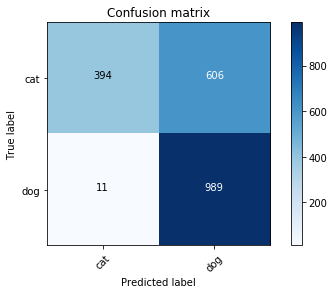

In [82]:
plot_confusion_matrix(cm, {'cat':0, 'dog':1})

## 训练更多层

Now that we've fine-tuned the new final layer, can we, and should we, fine-tune *all* the dense layers? The answer to both questions, it turns out, is: yes! Let's start with the "can we" question...

现在，我们微调的新的最后一层，我们能够微调所有的全链接层吗？

### 反向传播介绍

The key to training multiple layers of a model, rather than just one, lies in a technique called "back-propagation" (or *backprop* to its friends). Backprop is one of the many words in deep learning parlance that is creating a new word for something that already exists - in this case, backprop simply refers to calculating gradients using the *chain rule*. (But we will still introduce the deep learning terms during this course, since it's important to know them when reading about or discussing deep learning.)

As you (hopefully!) remember from high school, the chain rule is how you calculate the gradient of a "function of a function"--something of the form *f(u), where u=g(x)*. For instance, let's say your function is ```pow((2*x), 2)```. Then u is ```2*x```, and f(u) is ```power(u, 2)```. The chain rule tells us that the derivative of this is simply the product of the derivatives of f() and g(). Using *f'(x)* to refer to the derivative, we can say that: ```f'(x) = f'(u) * g'(x) = 2*u * 2 = 2*(2*x) * 2 = 8*x```.

Let's check our calculation:

In [83]:
# sympy let's us do symbolic differentiation (and much more!) in python
import sympy as sp
# we have to define our variables
x = sp.var('x')
# then we can request the derivative or any expression of that variable
pow(2*x,2).diff()

8*x

The key insight is that the stacking of linear functions and non-linear activations we learnt about in the last section is simply defining a function of functions (of functions, of functions...). Each layer is taking the output of the previous layer's function, and using it as input into its function. Therefore, we can calculate the derivative at any layer by simply multiplying the gradients of that layer and all of its following layers together! This use of the chain rule to allow us to rapidly calculate the derivatives of our model at any layer is referred to as *back propagation*.

The good news is that you'll never have to worry about the details of this yourself, since libraries like Theano and Tensorflow (and therefore wrappers like Keras) provide *automatic differentiation* (or *AD*). ***TODO***

### 在Keras中训练多个层

The code below will work on any model that contains dense layers; it's not just for this VGG model.

NB: Don't skip the step of fine-tuning just the final layer first, since otherwise you'll have one layer with random weights, which will cause the other layers to quickly move a long way from their optimized imagenet weights.

In [84]:
layers = model.layers

In [85]:
layers

In [86]:
[index for index,layer in enumerate(layers) if type(layer) is Dense][0]

33

In [87]:
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: 
    layer.trainable=True

Since we haven't changed our architecture, there's no need to re-compile the model - instead, we just set the learning rate. Since we're training more layers, and since we've already optimized the last layer, we should use a lower learning rate than previously.

我们这样就改变了模型结构，这里并不需要重新编译模型，而是仅仅更改学习率。因为我们需要训练更多的层，同时我们已经训练好了最后一层，所以我们需要一个比之前更低的学习率。

In [88]:
K.set_value(opt.lr, 0.01)
fit_model(model, batches, val_batches, 3)

Epoch 1/3
  1/125 [..............................] - ETA: 19s - loss: 6.0443 - acc: 0.6250

C:\Anaconda3\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


125/125 [==============================] - 31s 245ms/step - loss: 4.2942 - acc: 0.7305 - val_loss: 3.4219 - val_acc: 0.7835
Epoch 2/3
125/125 [==============================] - 31s 245ms/step - loss: 3.1749 - acc: 0.7990 - val_loss: 2.3067 - val_acc: 0.8550
Epoch 3/3
125/125 [==============================] - 31s 245ms/step - loss: 2.4665 - acc: 0.8450 - val_loss: 2.2643 - val_acc: 0.8545


This is an extraordinarily powerful 5 lines of code. We have fine-tuned all of our dense layers to be optimized for our specific data set. This kind of technique has only become accessible in the last year or two - and we can already do it in just 5 lines of python!

In [89]:
model.save_weights(model_path+'finetune2.h5')

There's generally little room for improvement in training the convolutional layers, if you're using the model on natural images (as we are). However, there's no harm trying a few of the later conv layers, since it may give a slight improvement, and can't hurt (and we can always load the previous weights if the accuracy decreases).

In [90]:
for layer in layers[12:]: 
    layer.trainable=True
K.set_value(opt.lr, 0.001)

In [91]:
fit_model(model, batches, val_batches, 4)

Epoch 1/4
  1/125 [..............................] - ETA: 17s - loss: 2.0148 - acc: 0.8750

C:\Anaconda3\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


125/125 [==============================] - 31s 246ms/step - loss: 2.4793 - acc: 0.8430 - val_loss: 2.2642 - val_acc: 0.8555
Epoch 2/4
125/125 [==============================] - 31s 247ms/step - loss: 2.5657 - acc: 0.8380 - val_loss: 2.2650 - val_acc: 0.8550
Epoch 3/4
125/125 [==============================] - 31s 247ms/step - loss: 2.1890 - acc: 0.8605 - val_loss: 2.2708 - val_acc: 0.8560
Epoch 4/4
125/125 [==============================] - 31s 249ms/step - loss: 2.3187 - acc: 0.8510 - val_loss: 2.2617 - val_acc: 0.8570


In [92]:
model.save_weights(model_path+'finetune3.h5')

You can always load the weights later and use the model to do whatever you need:

In [93]:
model.load_weights(model_path+'finetune2.h5')
model.evaluate_generator(get_batches(path+'valid', gen, False, batch_size*2), val_batches.n)

Found 2000 images belonging to 2 classes.


[2.2618036316395655, 0.8546390778533636]

In [94]:
val_batches.n

2000